# POS-tagging using HMM (Hidden Markov model)

This is HMM part-of-speech tagger

**Author**: Ruslan Sabirov

**Collab link**: [link](https://drive.google.com/file/d/1BRLI7pSZJw3o0jnYtLUVNIzn7lv6vnb3/view?usp=sharing)


In [0]:
!pip install conllu
!pip install tqdm
!pip install termcolor
!pip install sklearn
!pip install sklearn
!pip install seaborn
!pip install pandas

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
!cd 'drive/My Drive/S20/NLP'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from conllu import parse_incr
from tqdm import tqdm
from termcolor import colored

class CountDict(dict):
    """
    Class that is used as counter, inherited from dict. 
    """
    def __getitem__(self, item):
        """
        Gets item without exceptions
        :param item:  key you want to get
        :return: value, associated with `item` (if item in the `keys`), 0 otherwise
        """
        if item not in self:
            return 0
        return super().__getitem__(item)
    
    def make_probabilistic(self):
        """
        Converts values from counts to probabilities
        """
        n = sum(self.values())
        for item in self:
            self[item] /= n


OPEN_TAGS = ['ADJ', 'ADV', 'INTJ', 'NOUN','PROPN', 'VERB']  # open-set
CLOSED_TAGS = ['ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART',	'PRON', 'SCONJ']  # closed-set
OTHER_TAGS = ['PUNCT', 'SYM', 'X', 'START', 'END']
TAGS = OPEN_TAGS + CLOSED_TAGS + OTHER_TAGS  # list of possible tags
tags_distribution = CountDict()  # how many times each tag is observed

## Viterbi algorithm
As an input Viterbi algorithm takes `observation` (sentence to be tagged), 
`transition` (matrix of tags transition probabilities),
`emission` (matrix of tokens probabilities for a given tag).

Viterbi algorithm is an example of dynamic programming. It uses previously computed answers for smaller tasks 
to compute the answer for big task. Time complexity of the algorithm is `O(|sentence| * |tags| ^ 2`, 
where `|sentence|` is lenght of input sentence and `|tags|` is length of set of all possible POS-tags.

In [0]:
def viterbi(observation, transition, emission, most_frequent_tag):
    # Add START and END tokens to the observation if there is no
    if observation[0] != 'START' and observation[-1] != 'END':
        observation = ['START'] + observation + ['END']

    dp = [
        {tag: 0 for tag in TAGS}
        for _ in range(len(observation))
    ]
    path = [
        {tag: 0 for tag in TAGS}
        for _ in range(len(observation))
    ]
    
    dp[0]['START'] = 1
    for step in range(1, len(dp)):        
        token = observation[step]
        
        for tag in dp[step]:            
            prev_tag = 'END'
            for t in dp[step-1]: 
                if dp[step - 1][t] * transition[t][tag] >= dp[step - 1][prev_tag] * transition[prev_tag][tag]:
                    prev_tag = t
            if prev_tag == 'END': # unknown word
                prev_tag = most_frequent_tag
            
            path[step][tag] = prev_tag
            prev_prob = dp[step - 1][prev_tag]
            emission_prob = emission[tag][token]
            transition_prob = transition[prev_tag][tag]
            cur_prob = prev_prob * transition_prob * emission_prob
            dp[step][tag] = cur_prob
    
    tags = []
    tag = 'END'
    for i in range(len(dp) - 1, -1, -1):
        tags.append(tag)
        tag = path[i][tag]   
    tags.reverse()
    return tags

## Training and testing

I have divided algorithm into **two parts**: training and testing:
* Training part learns the structure of the data, determines POS-tags distribution and 
constructs `transition` and `emission` matrices.
* Testing part uses learned properties for predicting the POS-tag. It applies Viterbi algorithm. 

In [0]:
def train_model(file):
    global tags_distribution
    
    transitions = {
        tag: CountDict()
        for tag in TAGS
    }
    emissions = {
        tag: CountDict()
        for tag in TAGS
    }
    emissions['START'] = CountDict()
    emissions['START']['START'] = 1
    emissions['END'] = CountDict()
    emissions['END']['END'] = 1
    
    tags_distribution = CountDict()
    
    for sample in tqdm(parse_incr(file), desc='Training'):
        
        tokens = ['START'] + [token['form'].lower() for token in sample.tokens] + ['END']
        pos_tags = ['START'] + [token['upostag'] for token in sample.tokens] + ['END']
        for i in range(1, len(tokens)):
            token = tokens[i]
            tag = pos_tags[i]
            prev_tag = pos_tags[i - 1]
            tags_distribution[tag] += 1
            transitions[prev_tag][tag] += 1
            emissions[tag][token] += 1
       
    most_frequent_tag = OPEN_TAGS[0]
    for tag in OPEN_TAGS:
        if tags_distribution[tag] > tags_distribution[most_frequent_tag]:
            most_frequent_tag = tag
            
    for x in transitions:
        transitions[x].make_probabilistic()
    for x in emissions:
        emissions[x].make_probabilistic()
    
    return transitions, emissions, most_frequent_tag

In [0]:
samples_classified = []
tokens_classified = []


def test_model(file, transitions, emissions, most_frequent_tag):
    global samples_classified, tokens_classified

    error_samples = 0
    total_samples = 0
    error_tags = 0
    total_tags = 0
    
    for sample in tqdm(parse_incr(file), desc='Testing'):
        tokens = ['START'] + [token['form'].lower() for token in sample.tokens] + ['END']
        correct_tags = ['START'] + [token['upostag'] for token in sample.tokens] + ['END']
        predicted_tags = viterbi(tokens, transitions, emissions, most_frequent_tag)
        total_samples += 1
        if correct_tags != predicted_tags:
            error_samples += 1
        samples_classified.append((tokens, correct_tags, predicted_tags))
            
        for i in range(len(correct_tags)):
            total_tags += 1
            tokens_classified.append((tokens[i], correct_tags[i], predicted_tags[i]))
            if correct_tags[i] != predicted_tags[i]:
                error_tags += 1
                
    sentence_accuracy = (1 - error_samples/total_samples) * 100
    tag_accuracy = (1 - error_tags/total_tags) * 100
    print()
    print(colored(f'Sentence accuracy: {sentence_accuracy}', 'red'))
    print(colored(f'Tags accuracy: {tag_accuracy}', 'red'))


## The data

I am using [UD-English-EWT dataset](https://universaldependencies.org/), which is the larges among UD-English dataset
(254 856 tokens, 16 622 sentences). It consist of samples from blogs, e-mails, news, social, 
I am assuming that language would be simple and number of domain-specific words should not be very large 
as it would be with sentences from Wikipedia, or Legal or Academic spheres.

The corpus of sentences annotated using Universal Dependencies annotation.

Data is already splitted into training and testing parts in proportion: 75% for training set and 15% for testing set.  

Data is stored in the format `conllu`, which is very popular for NLP tasks.

## Accuracies

I have decided to count both sentence accuracy and token accuracy. Sentence accuracy is the proportion of sentences 
that were classified correctly.  Tokens accuracy is the proportion of tokens 
that were classified correctly (no matter of sentence). 
Here is a table of accuracies depending on used algorithm:
* Standart Viterbi algorithm takes any random tag for unknown word.
* Most frequent tag algorithm always uses the most frequent tag for all unknown words.

ALGORITHM NAME ⠀| SAMPLE ACCURACY ⠀| TOKEN ACCURACY

Standart Viterbi⠀⠀ ⠀| 34% ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀| 61%

Most frequent tag⠀⠀| 35% ⠀⠀⠀⠀⠀⠀ ⠀ ⠀⠀⠀ | 69%

If we use the same dataset (en_ewt-ud-train) for both training and testing accuracies would increase to 52% and 95% respectively. The reason of that is because of fact that there will be no unknown words during testing.

In [0]:
!pwd

dataset = 'drive/My Drive/S20/NLP/UD_English-EWT/en_ewt-ud-{}.conllu'

train_name = dataset.format('train')
train_file = open(train_name, 'r', encoding='utf-8')

transitions, emissions, most_frequent_tag = train_model(train_file)


/content


Training: 12543it [00:05, 2237.22it/s]


In [0]:
test_name = dataset.format('test')
test_file = open(test_name, 'r', encoding='utf-8')
test_model(test_file, transitions, emissions, most_frequent_tag)


Testing: 2077it [00:11, 174.57it/s]


Sentence accuracy: 34.71352912855079
Tags accuracy: 68.57201463197839


## Examples of classified sentences

Correctly classified sentences are represented with green, incorrect ones with red.

In [0]:
def print_tagged_sentence(sentence, tags, color):
    sentence = sentence[1:-1]
    tags = tags[1:-1]
    for i in range(len(sentence)):
        print(sentence[i], end='\\')
        print(colored(tags[i], color), end='   ')
    print()

for i in range(10):
    example = samples_classified[i]
    sent, true, pred = example
    if true == pred:
        print('Correctly')
        print_tagged_sentence(sent, true, 'blue')
        print_tagged_sentence(sent, pred, 'green')
    else:
        print('Incorrectly')
        print_tagged_sentence(sent, true, 'blue')
        print_tagged_sentence(sent, pred, 'red')
    print()
    print()
    


Incorrectly
what\PRON   if\SCONJ   google\PROPN   morphed\VERB   into\ADP   googleos\PROPN   ?\PUNCT   
what\PRON   if\SCONJ   google\PROPN   morphed\NOUN   into\NOUN   googleos\NOUN   ?\NOUN   


Incorrectly
what\PRON   if\SCONJ   google\PROPN   expanded\VERB   on\ADP   its\PRON   search\NOUN   -\PUNCT   engine\NOUN   (\PUNCT   and\CCONJ   now\ADV   e-mail\NOUN   )\PUNCT   wares\NOUN   into\ADP   a\DET   full\ADV   -\PUNCT   fledged\ADJ   operating\NOUN   system\NOUN   ?\PUNCT   
what\PRON   if\SCONJ   google\PROPN   expanded\VERB   on\ADP   its\PRON   search\NOUN   -\PUNCT   engine\NOUN   (\PUNCT   and\CCONJ   now\ADV   e-mail\NOUN   )\PUNCT   wares\NOUN   into\NOUN   a\NOUN   full\NOUN   -\NOUN   fledged\NOUN   operating\NOUN   system\NOUN   ?\NOUN   


Incorrectly
[\PUNCT   via\ADP   microsoft\PROPN   watch\PROPN   from\ADP   mary\PROPN   jo\PROPN   foley\PROPN   ]\PUNCT   
[\PUNCT   via\ADP   microsoft\PROPN   watch\VERB   from\ADP   mary\PROPN   jo\NOUN   foley\NOUN   ]\NOUN   



## Confusion matrix

Here is an confusion matrix, each row and column is labeled as one of the tags. 
`confusion_matrix[row][column]` represents number of tokens that actually have `row` tag but werewere classified as `column` tag.

As we can see, most of the wrong predictions were made on `NOUN` tag, which is the most popular among others.

Most of the wrognly classified tokens belongs to tags `VERB`, `ADP`, `ADJ`

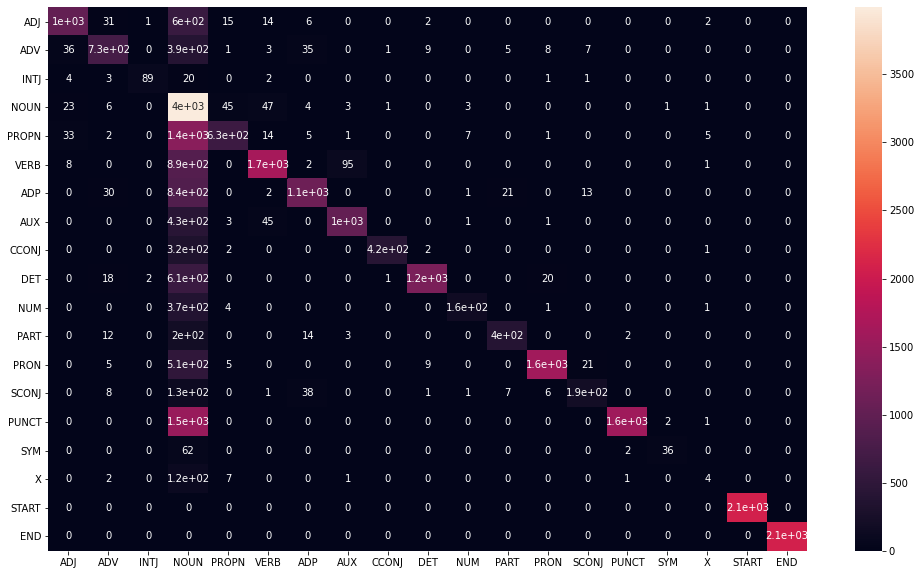

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

y_true = [s[1] for s in tokens_classified]
y_pred = [s[2] for s in tokens_classified]
cm = confusion_matrix(y_true, y_pred, labels=TAGS)

df_cm = pd.DataFrame(cm, index=TAGS, columns=TAGS)
plt.figure(figsize = (17,10), )
sn.heatmap(df_cm, annot=True)